# TNG Playground

This notebook serves as a sandbox, set up for easy access to TNG data. It is used to quickly load TNG simulation data, play round with it, determine quantities etc. 

## Set-up

Setting up the Python env

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# IMPORTS
import h5py
import logging
import logging.config
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import os
import sys
from numpy.typing import ArrayLike
from pathlib import Path
from typing import Any, Union

import illustris_python as il

Importing helper scripts

In [12]:
# import the helper scripts
module_path = Path(os.getcwd()) / ".." / "src"
sys.path.append(str(module_path.resolve()))
import logging_config 
import processors
import config
import constants

Set up a small logging environment for impromptu logging during lengthy operations:

In [13]:
logging_cfg = logging_config.get_logging_config("INFO")
logging.config.dictConfig(logging_cfg)
logger = logging.getLogger("root")
# test setup
logger.info("I am a test log!")

INFO: I am a test log!


Define some globals that point to different simulations:

In [14]:
TEST_SIM = "TNG50-4"
DEV_SIM = "TNG300-2"
MAIN_SIM = "TNG300-1"

## Probing plots

Firstly, the distribution of masses in the simulation should be probed to get an idea of how to best bin the halos by mass.

In [6]:
def plot_halo_mass_distribution() -> None:
    """Plot the mass distribution of halos in TNG300-1"""
    logger.info("Loading halo mass data.")
    cfg = config.get_default_config(MAIN_SIM)
    masses = il.groupcat.loadHalos(
        cfg.base_path, cfg.snap_num, fields=cfg.mass_field
    )
    # adjust for units
    masses = masses * 1e10 / constants.HUBBLE

    max_mass = np.max(masses)

    # plot hist of masses in log scale
    logger.info("Plotting histrogram.")
    fig, axes = plt.subplots(figsize=(5, 5))
    axes.set_xlabel(r"Masses ($M_{Crit, 200}$) [$\log M_\odot$]")
    axes.set_ylabel("Count")
    axes.set_title("Mass distribution in TNG300-1")
    plot_config = {
        "bins": 40,
        "histtype": "stepfilled",
        "log": False,
        "edgecolor": "black",
        "facecolor": "crimson",
    }
    # plot only the log and exclude masses near zero
    axes.hist(np.log10(masses[(masses > 1)]), **plot_config)
    # add info on min and max mass
    axes.text(11.8, 2e5, rf"Max mass: ${max_mass:.2e} M_\odot$")


INFO: Loading halo mass data.


INFO: Plotting histrogram.


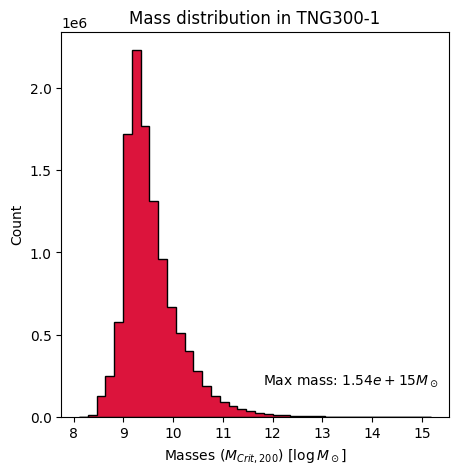

In [7]:
plot_halo_mass_distribution()

Judging by this, it is sensible to consider masses ranging from $10^8 M_\odot$ up to around $10^{15} M_\odot$, but given the fact that an overwhelmin majority of halos have masses between $10^8 M_\odot$ and $10^{12} M_\odot$, it might be advisable to exclude very high mass bins in the beginning and only consider them for plots of individual halo temperature distributions.

## File size estimates

Estimating how much space on disk it would take to save histograms of all halos in TNG300-1 to file. Every histogram is a numpy array of size (50,) and of data type float32. This means that the total array will occupy $N \cdot 50 \cdot 32 \ \text{bytes}$ on disk, where $N$ is the number of halos in TNG300-1. We can easily find the total file soze then as follows:

In [8]:
def estimate_file_size_for_hists() -> float:
    """
    Return file size for histogram data saved to file in MB.
    """
    NUM_BINS = 50
    cfg = config.get_default_config(MAIN_SIM)
    f = h5py.File(il.groupcat.gcPath(cfg.base_path, cfg.snap_num, 0), 'r')
    n_groups = f["Header"].attrs["Ngroups_Total"]
    f.close()
    print(f"Total number of halos: {n_groups:,.0f}")
    # calculate file size
    size = sys.getsizeof(np.zeros(NUM_BINS, dtype="float32"))
    file_size_in_bytes = size * n_groups
    return file_size_in_bytes / 1024. / 1024.

In [9]:
filesize = estimate_file_size_for_hists()
print(f"Estimated size on disk: {filesize:.2f} MB")

Total number of halos: 17,625,892
Estimated size on disk: 5244.52 MB


Similarly, we want to estimate how much space in memory it will take up to load four fields of all particles in TNG300-1.

In [10]:
def estimate_memory_size_for_particle_data() -> float:
    """
    Return size in memory for gas data with four fields in GB.
    """
    NUM_FIELDS = 4
    cfg = config.get_default_config(MAIN_SIM)
    f = h5py.File(il.snapshot.snapPath(cfg.base_path, cfg.snap_num, 0), 'r')
    n_part = f["Header"].attrs["NumPart_Total"][0]
    f.close()
    size = sys.getsizeof(np.zeros(n_part, dtype="float32"))
    memsize = NUM_FIELDS * size
    return memsize / 1024. / 1024. / 1024.

In [11]:
memsize = estimate_memory_size_for_particle_data()
print(f"Estimated size in memory: {memsize:.4f} GB")

Estimated size in memory: 23.3921 GB


## Exploring offsets

Here we want to understand how offset files work: what do offsets loaded with `il.snapshot.getSnapOffsets` look like, what do the individual offsets reprsent and most importantly: which offset gives us the first particle ID in a FoF group.

In [12]:
def explore_offsets() -> dict:
    cfg = config.get_default_config(MAIN_SIM)
    offsets = il.snapshot.getSnapOffsets(cfg.base_path, cfg.snap_num, 28364, "Group")
    print(f"Shape of 'snapOffsets': {offsets['snapOffsets'].shape}")
    print(f"Shape of 'lenType': {offsets['lenType'].shape}, type: {type(offsets['lenType'][0])}")
    print(f"Shape of 'offsetType': {offsets['offsetType'].shape}, type: {type(offsets['offsetType'][0])}")
    return offsets

In [13]:
%time explore_offsets()

Shape of 'snapOffsets': (6, 600)
Shape of 'lenType': (6,), type: <class 'numpy.int32'>
Shape of 'offsetType': (6,), type: <class 'numpy.int64'>
CPU times: user 88 µs, sys: 4.12 ms, total: 4.2 ms
Wall time: 60.1 ms


{'snapOffsets': array([[          0,    23851047,    47762531, ..., 14382702488,
         14406373170, 14430545360],
        [          0,    25680412,    51322410, ..., 15546108263,
         15572641241, 15598828199],
        [          0,           0,           0, ...,           0,
                   0,           0],
        [          0,    27199194,    54194711, ..., 15531779586,
         15561116312, 15592723539],
        [          0,     1787650,     3494151, ...,   708520692,
           709748698,   710864666],
        [          0,        1103,        2201, ...,      697660,
              698785,      699983]]),
 'lenType': array([ 8411, 30518,     0,     0,  4194,     2], dtype=int32),
 'offsetType': array([2488838398, 4775404601,          0,          0,  571438234,
            156918])}

It appears that `lenType` gives the number of particles per type in the given halo, while `offsetType` gives the index of the first particle of every type belonging to that halo. This way, one can get all particles of particle type `i` by slicing an array of all particles of type `i` using

```python
halo_particles = type_i_particles[offsets["offsetType"][i] : offsets["offsetType"][i] + offsets["lenType"][i]]
```

The `snapOffsets` are probably the offsets of the first particle of every type across all snapshots.

## Comparing virial temperature estimates

We have two virial temperature estimates that we want to compare: firstly, the virial temperature estimate from Nelson et al. (2013), which is based on Barkana & Loeb (2001) and which assumes a molecular mean weight of $\mu \sim 0.6$ and a virial radius fully determined by the mass:

$$T_{vir} \simeq 4 \cdot 10^5 \text{K} \left( \dfrac{M}{10^{11} h^{-1} M_\odot} \right)^\frac{2}{3} \left( \dfrac{1 + z}{3} \right)$$

Secondly, we have the estimate derived ourselves directly from the virial theorem, assuming the halo is virialized and the velocities within are thermal velocities, caused purely by the gravitational potential:

$$T_{vir} \simeq \dfrac{2}{5} \dfrac{G M m_p}{R k_B}$$

We might wish to improve this relation by replacing the pure proton mass with the term $\mu m_p$ for more accuracy. This is (sans the pre-factor) equivalent to the formula for virial temperature in Barkana & Loeb (2001):

$$T_{vir} \simeq \dfrac{\mu m_p}{2k_B} \dfrac{GM}{R}$$

We now want to see how these compare.

In [32]:
def virial_temperature_nelson(mass: float) -> float:
    """Return virial temperature according to Nelson et al. (2013)"""
    return 4e5 * (mass / (1e11 * (constants.HUBBLE)**(-1)))**(2/3) / 3
                  

def virial_temperature_simple(mass: float, radius: float) -> float:
    """Return the virial temperature according to a simple estimate"""
    numerator = 2 * constants.G * constants.m_p * mass * constants.M_sol
    denominator = 5 * radius * constants.kpc * constants.k_B
    return numerator / denominator


def virial_temperature_barakana_loeb(mass: float, radius: float) -> float:
    """
    Return the virial temperature according to Barkana & Loeb (2002)
    """
    numerator = 0.6 * constants.m_p * constants.G * constants.M_sol * mass
    denominator = 2 * constants.k_B * constants.kpc * radius
    return numerator / denominator


def compare_virial_temperatures(halo_id: int) -> None:
    """
    Calculate halo virial temperature in three ways and print result

    :param halo_id: The halo ID of the halo to use.
    """
    cfg = config.get_default_config(MAIN_SIM)
    halo_data = il.groupcat.loadSingle(cfg.base_path, cfg.snap_num, haloID=halo_id)
    mass = halo_data[cfg.mass_field] * 1e10 / constants.HUBBLE
    radius = halo_data[cfg.radius_field] / constants.HUBBLE

    if radius == 0:
        print("Halo has no virial radius, skipping.")
        return

    # out put comparison
    print(f"Nelson: log T = {np.log10(virial_temperature_nelson(mass))}")
    print(f"Simple: log T = {np.log10(virial_temperature_simple(mass, radius))}")
    print(f"B&L: log T = {np.log10(virial_temperature_barakana_loeb(mass, radius))}")

In [33]:
print("Halo with ID 12:")
compare_virial_temperatures(12)
print("")

for _ in range(5): 
    id = np.random.randint(0, 17_000_000)
    print(f"Halo with ID {id}:")
    compare_virial_temperatures(id)
    print("")

Halo with ID 12:
Nelson: log T = 7.556409957182588
Simple: log T = 7.8725278666830665
B&L: log T = 7.747589130074766

Halo with ID 7082873:
Nelson: log T = 3.935538469466151
Simple: log T = 4.251644526023505
B&L: log T = 4.1267057894152055

Halo with ID 10294339:
Nelson: log T = 3.6425041935882088
Simple: log T = 3.9586149364247945
B&L: log T = 3.8336761998164945

Halo with ID 3727479:
Nelson: log T = 4.148963730529977
Simple: log T = 4.465076389634558
B&L: log T = 4.340137653026258

Halo with ID 10214430:
Nelson: log T = 3.8040443454304427
Simple: log T = 4.120162767857839
B&L: log T = 3.9952240312495393

Halo with ID 11546418:
Nelson: log T = 3.8907935299756193
Simple: log T = 4.2069176649920825
B&L: log T = 4.081978928383783



We see that the estimation from Nelson (2013) is noticably smaller than the two other estimates. The difference between the last two values is explained by the different coeffcient, of course. 